In [1]:
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
SHIFT_FACTOR = 1 / 5

In [3]:
def read_meta(display_id):
    meta = pd.read_csv('meta.csv')
    info = meta[meta['display_id'] == display_id]
    if info.empty: return
    
    title = info['title'].values[0]
    views_per_like = info['view_count'].values[0] / info['like_count'].values[0]
    view_count = info['view_count'].values[0] 
    like_count = info['like_count'].values[0]
    duration = info['duration'].values[0]
    
    return (title, round(views_per_like, 2), view_count, like_count, duration)

In [4]:
def get_total_laugh(y_preds, sr):
    total_laugh_cnt = 0
    total_laugh_sec = 0
    
    shift = int(sr * SHIFT_FACTOR)
    start, stop = 0, shift
    t = 0

    is_sequence = False
    
    for y_pred in y_preds:
        if is_sequence:
            if y_pred == 0:
                is_sequence = False
                stop = t + shift
                duration = (stop - start)/sr
                
                if duration >= 1:
                    total_laugh_cnt += 1
                    total_laugh_sec += duration
        else:
            if y_pred == 1:
                is_sequence = True
                start = t

        t += shift
    
    return total_laugh_sec, total_laugh_cnt

In [5]:
def get_sample_rate(audio_file):
    _, sr = librosa.load(audio_file, sr=None, mono=True)
    return sr

In [6]:
def plot_laugh_segments(y_preds, sr):
    fig, _ = plt.subplots(figsize=(30, 4))
    plt.axis('off')
    plt.tick_params(
        axis='both',       # changes apply to both axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        right=False,
        left=False,
        labelbottom=False, # labels along the bottom edge are off
        labelleft=False) 

    shift = int(sr * SHIFT_FACTOR)
    start = 0
    stop = 0
    t = 0

    is_sequence = False
    for y_pred in y_preds:
        if is_sequence:
            if y_pred == 0:
                is_sequence = False
                stop = t + shift
                duration = (stop - start)/sr
                
                if duration >= 1:
                    plt.axvspan(xmin=start, xmax=stop, facecolor='#2ca02c', alpha=0.5)
        else:
            if y_pred == 1:
                is_sequence = True
                start = t

        t += shift
        
    return fig

In [7]:
def plot_laugh_over_time(y_preds, sr):
    shift = int(sr * SHIFT_FACTOR)
    t = 0
    window = [] # store 1 minute events
    start = 0;
    stop = 0
    is_sequence = True
    
    laughs_per_minute = []
    
    for y_pred in y_preds:
        if is_sequence:
            if y_pred == 0:
                is_sequence = False
                stop = t + shift
                duration = (stop - start)/sr
                
                if duration >= 2:
                    entry = (start, stop, duration)
                    window.append(entry)
        else:
            if y_pred == 1:
                is_sequence = True
                start = t
                
        if window:
            while ((window[-1][1] - window[0][0]) / sr) > 60:
                window.pop(0)

            laughs_per_minute.append(len(window))

        t += shift
    
    x = np.linspace(0, 100, len(laughs_per_minute))
    y = laughs_per_minute

    fig, _ = plt.subplots(figsize=(30, 4))
    plt.axis('off')
    plt.plot(x, y)
    plt.axhline(y=4, color='#ff0000', alpha=0.5)
    return fig
    

In [8]:
model = joblib.load('model.pkl')

THIAGO VENTURA - ESCOLA PUBLICA(wvzLATU8M04)
Views per like: 29.75	Total Laugh (sec): 115.8	Total Laugh (%): 0.3	Total Laugh (#): 49	Duration: 388


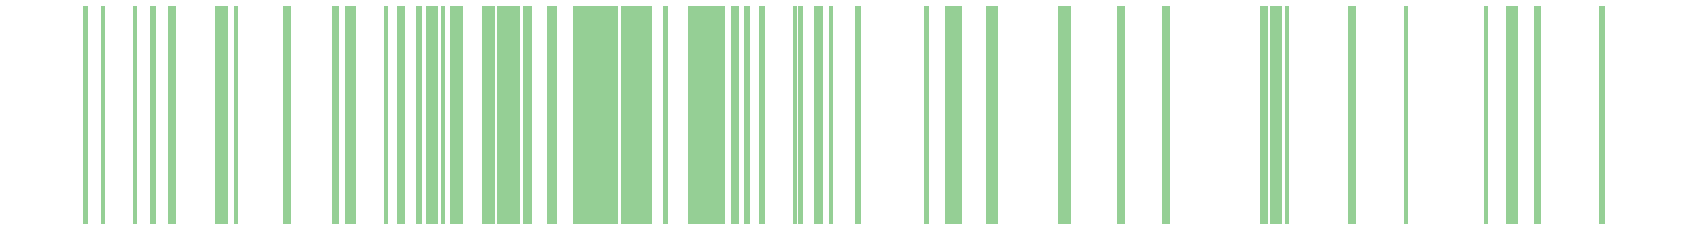

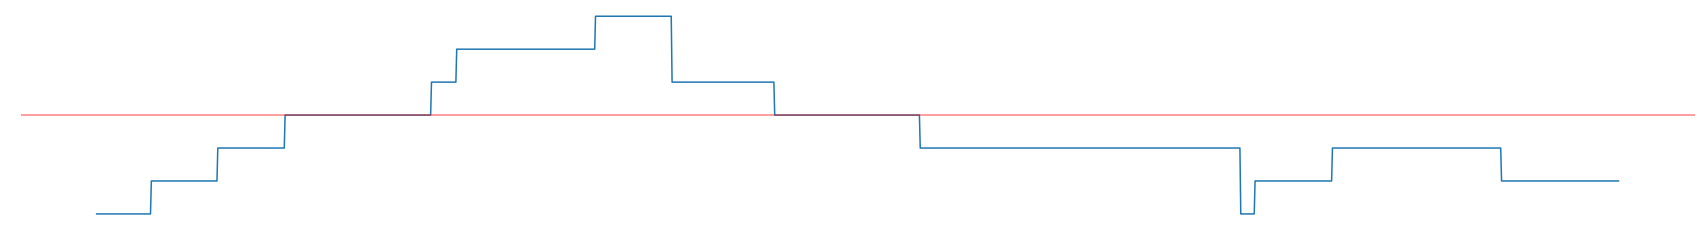

THIAGO VENTURA - O DIA QUE EU BROXEI(jaOEY8iRo6c)
Views per like: 22.2	Total Laugh (sec): 205.2	Total Laugh (%): 0.35	Total Laugh (#): 83	Duration: 593


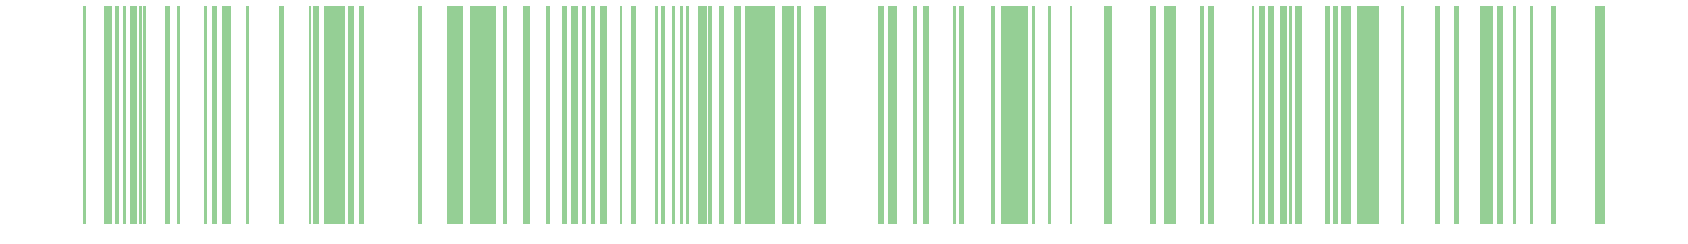

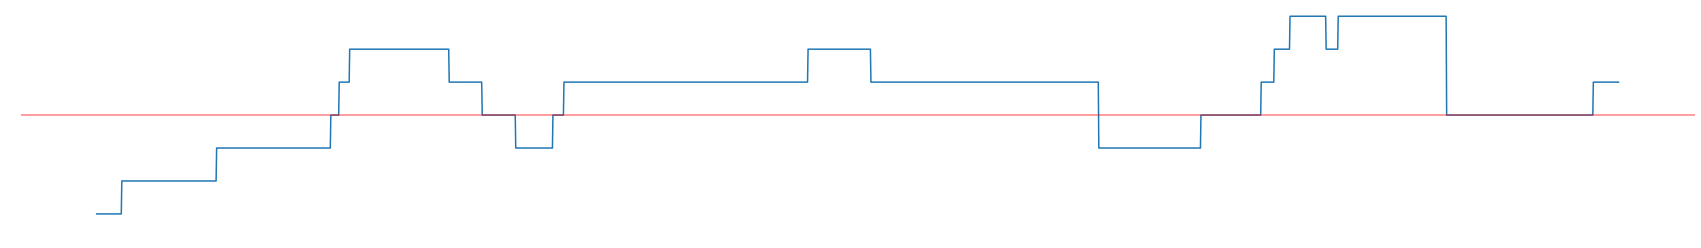

THIAGO VENTURA - INVEJA(Q2LDobhGHm4)
Views per like: 17.08	Total Laugh (sec): 243.6	Total Laugh (%): 0.39	Total Laugh (#): 80	Duration: 621


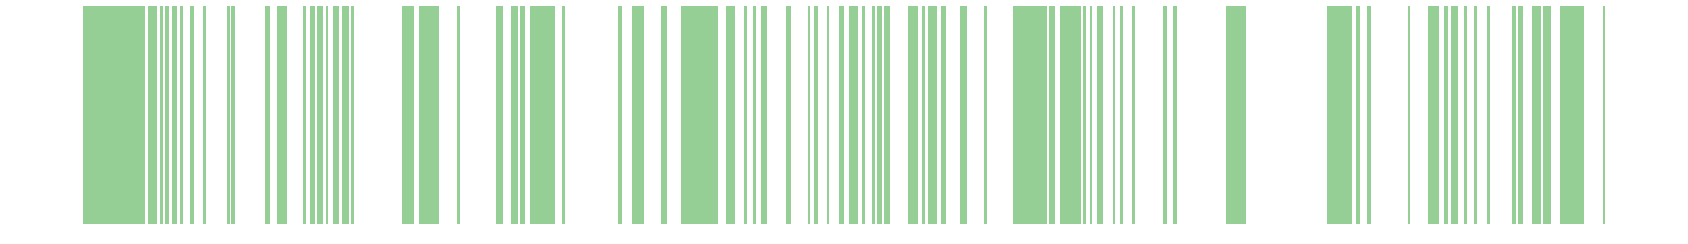

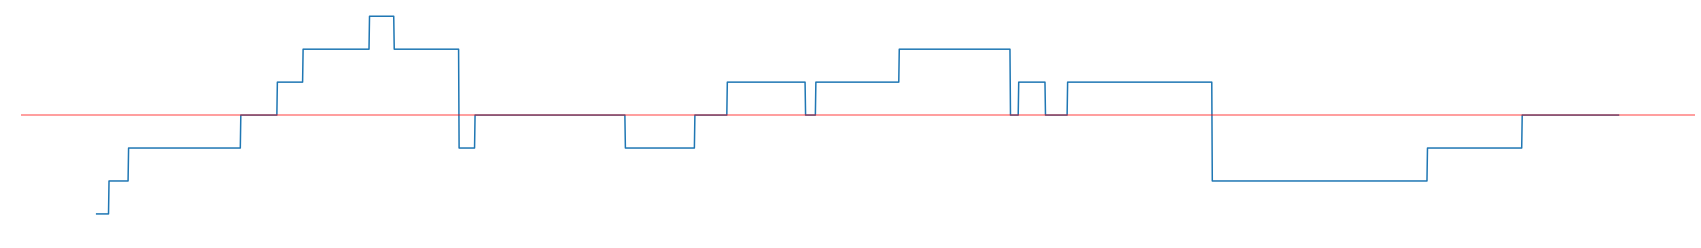

THIAGO VENTURA - OPERAÇÃO NO JOELHO(NcAZdATqkxA)
Views per like: 17.91	Total Laugh (sec): 298.4	Total Laugh (%): 0.44	Total Laugh (#): 113	Duration: 680


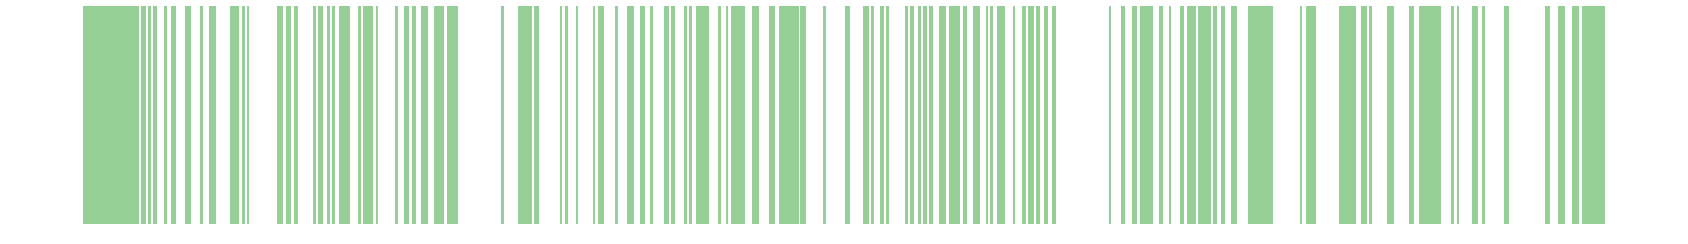

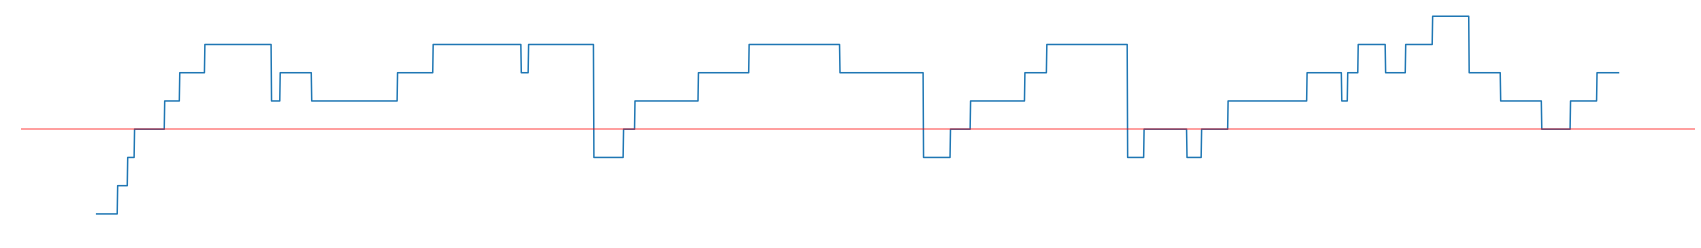

THIAGO VENTURA - MULHER COME MUITO(e8mvLIXoIug)
Views per like: 19.41	Total Laugh (sec): 144.8	Total Laugh (%): 0.34	Total Laugh (#): 59	Duration: 426


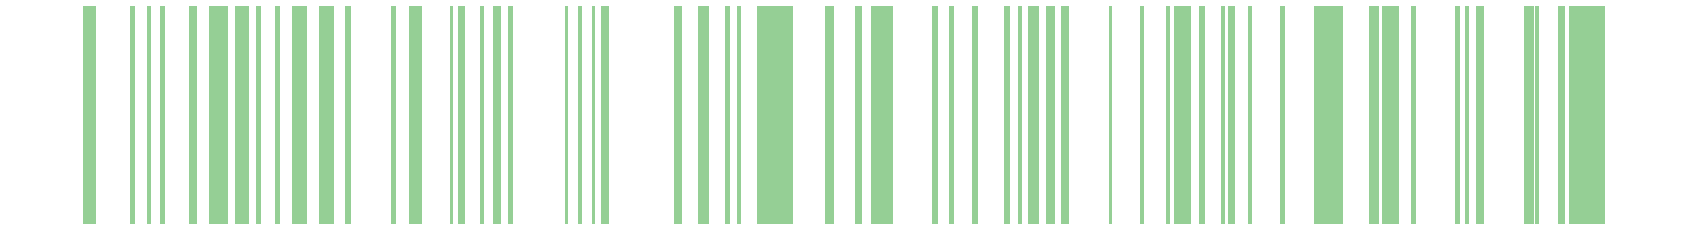

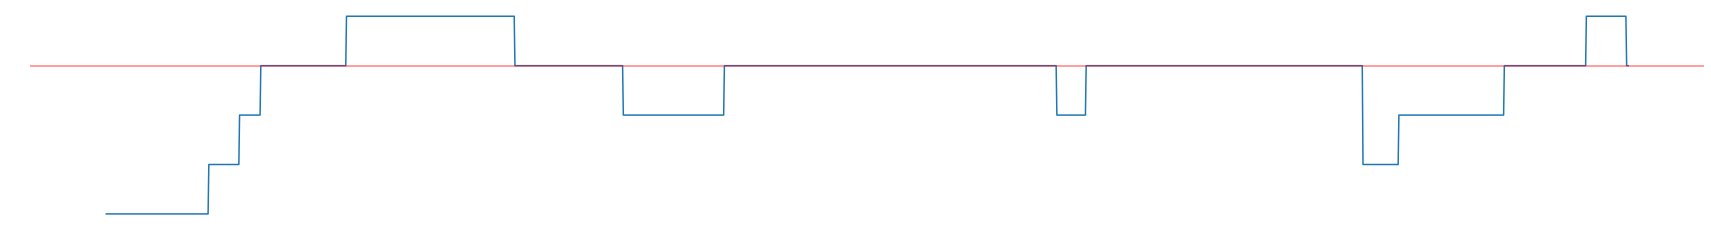

THIAGO VENTURA - BENZETACIL(WIVVb87JPog)
Views per like: 17.26	Total Laugh (sec): 166.0	Total Laugh (%): 0.33	Total Laugh (#): 73	Duration: 499


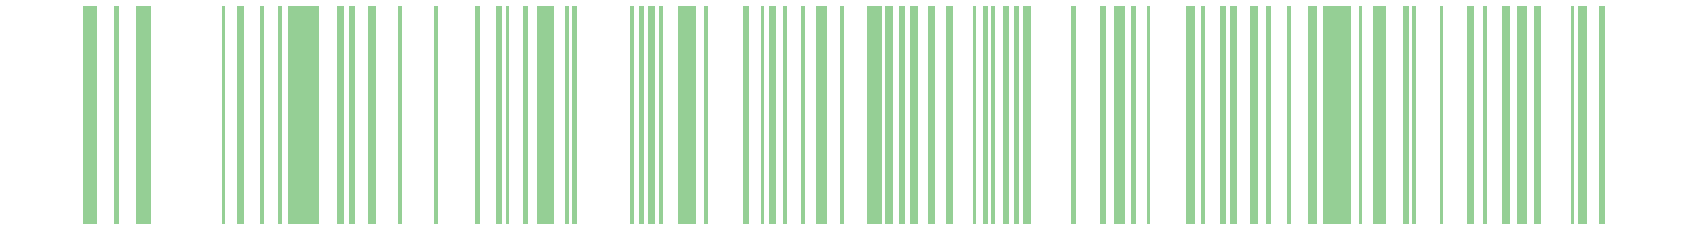

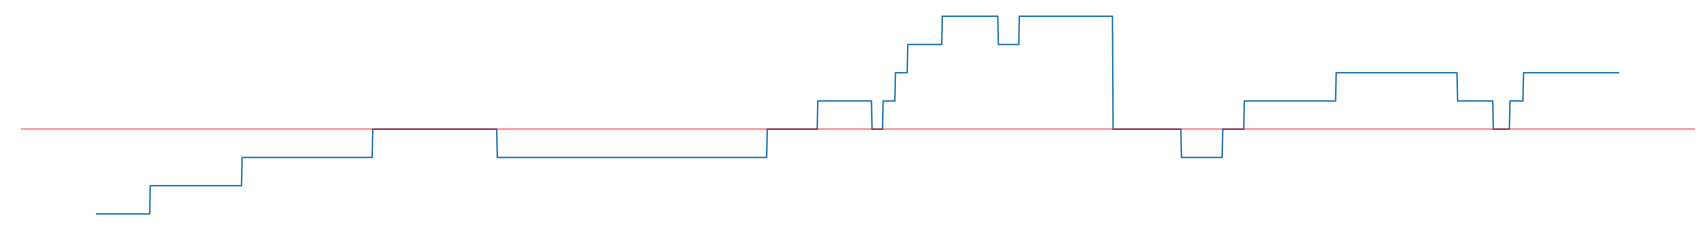

THIAGO VENTURA - CASAMENTO DO WHINDERSSON(UpX_kurvAXM)
Views per like: 14.61	Total Laugh (sec): 111.6	Total Laugh (%): 0.31	Total Laugh (#): 50	Duration: 361


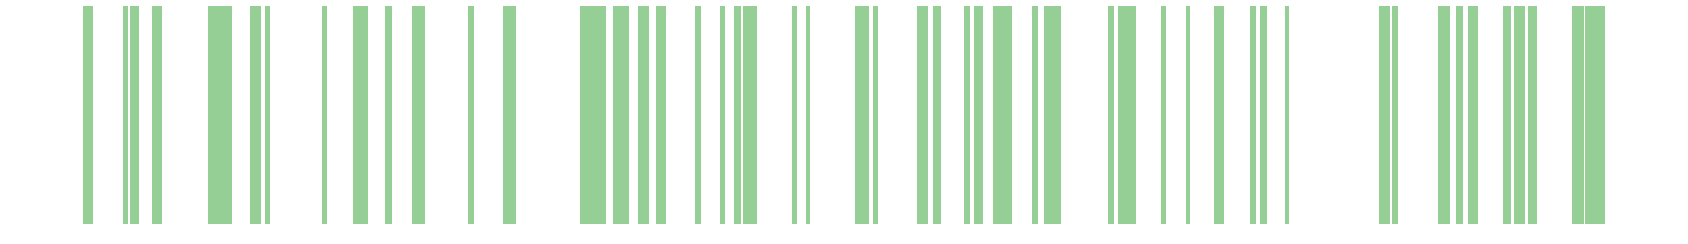

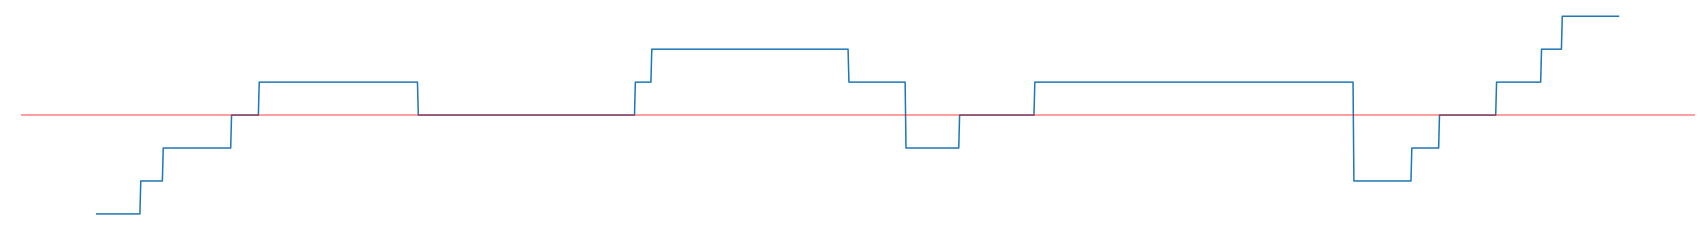

THIAGO VENTURA - MIAMI(IAzZnHwmBfc)
Views per like: 14.93	Total Laugh (sec): 336.8	Total Laugh (%): 0.48	Total Laugh (#): 126	Duration: 700


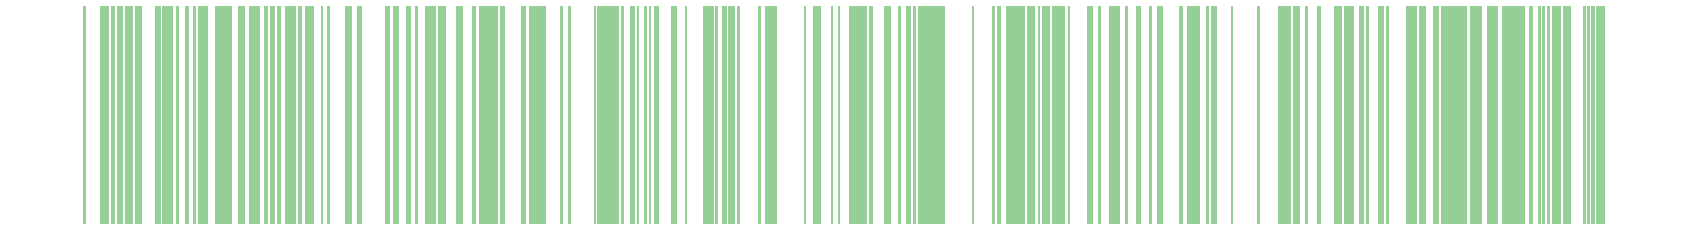

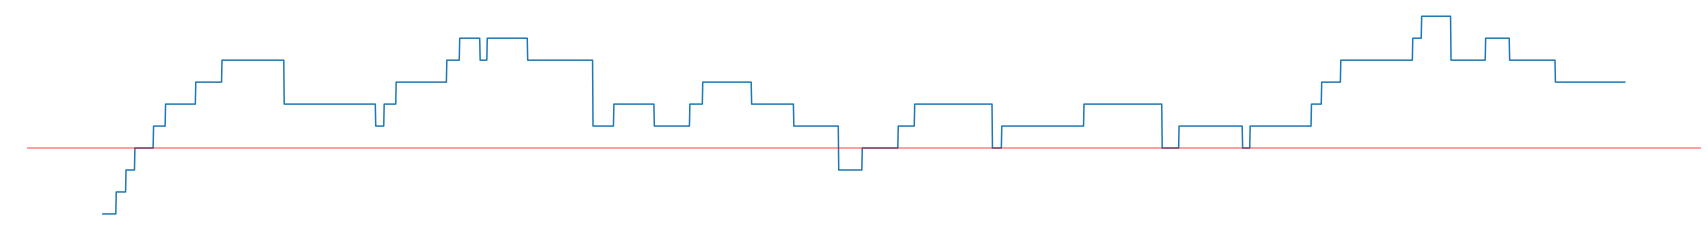

THIAGO VENTURA - SOBRE CENSURA(EEFInk9wlzs)
Views per like: 11.64	Total Laugh (sec): 155.2	Total Laugh (%): 0.41	Total Laugh (#): 43	Duration: 379


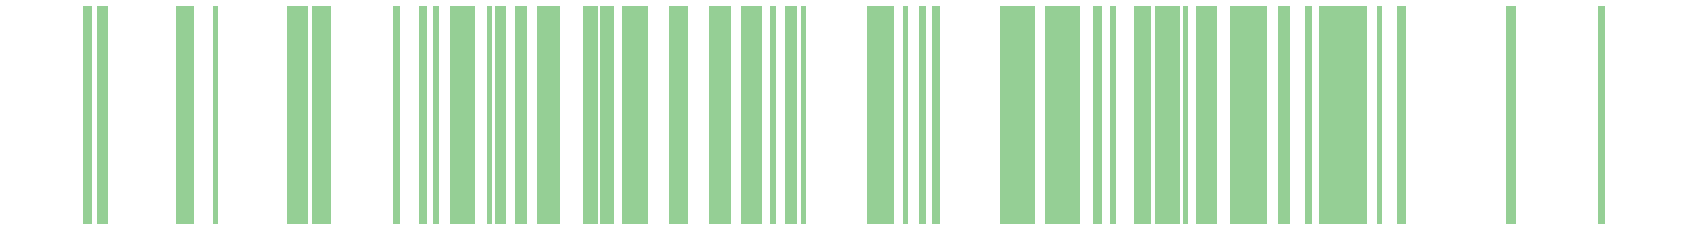

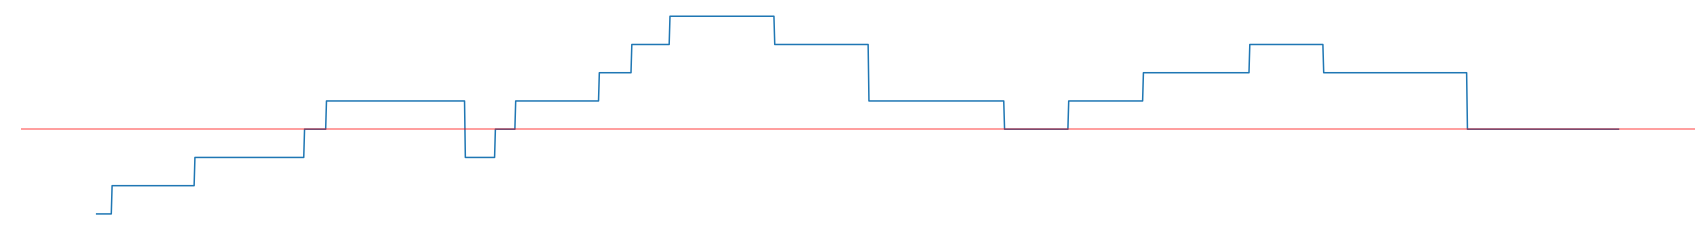

In [9]:
test_filenames = [
    'wvzLATU8M04',
    'jaOEY8iRo6c',
    'Q2LDobhGHm4',
    'NcAZdATqkxA',
    'e8mvLIXoIug',
    'WIVVb87JPog',
    'UpX_kurvAXM',
    'IAzZnHwmBfc',
    'EEFInk9wlzs',
]

for filename in test_filenames:
    X_test = pd.read_csv(filename + '.csv')
    ts_sr = get_sample_rate(filename + '.m4a')    
    y_preds  = model.predict(X_test)
    
    title, views_per_like, view_count, like_count, duration = read_meta(filename)
    total_laugh_sec, total_laugh_cnt = get_total_laugh(y_preds, ts_sr)
    print(title + "(" + filename + ")")
    print("Views per like: {}\tTotal Laugh (sec): {}\tTotal Laugh (%): {}\tTotal Laugh (#): {}\tDuration: {}".format(
        views_per_like, round(total_laugh_sec, 1), 
        round(total_laugh_sec/duration,2), 
        total_laugh_cnt, round(duration,1)))

    fig = plot_laugh_segments(y_preds, ts_sr)
    plt.show()
#     fig.savefig(filename + "_laugh_segments.png",bbox_inches='tight')
    
    fig = plot_laugh_over_time(y_preds, ts_sr)
    plt.show()
#     fig.savefig(filename + "_laugh_over_time.png")